# PTSD Detection from Sleep Data with a Hybrid Model
This notebook provides a deep learning model developed for the detection of Post-Traumatic Stress Disorder (PTSD) based on multimodal EEG and ECG data. The model uses a hybrid architecture including a CNN and a BiLSTM with an attention mechanism.

### 1. Required Libraries
In this cell, we import the necessary libraries to run the model.

In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

import mne
from scipy.signal import spectrogram, welch
from scipy.stats import zscore
import neurokit2 as nk

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit

torch.manual_seed(42)
np.random.seed(42)

### 2. Dataset Class and Data Preprocessing
The PTSDDataset class is responsible for loading, preprocessing, and extracting features (EEG spectrograms and HRV features) from the PSG files.

In [ ]:
class PTSDDataset(Dataset):
    def __init__(self, root_dir, labels_file, sequence_length=10, sfreq=100):
        self.root_dir = root_dir
        self.labels_file = labels_file
        self.sequence_length = sequence_length
        self.sfreq = sfreq

        self.labels_df = pd.read_csv(os.path.join(self.root_dir, self.labels_file))

        expected_cols = {'file_name', 'subject_id', 'ptsd_severity'}
        if not expected_cols.issubset(set(self.labels_df.columns)):
            raise ValueError(f"labels.csv must contain columns: {expected_cols}")

        self.sequences = self._load_and_preprocess_data()

    def _load_and_preprocess_data(self):
        all_epochs_list = []
        total_files = len(self.labels_df)

        eeg_channels = ['EEG Fpz-Cz', 'EEG Pz-Oz']
        ecg_channel = ['ECG']

        for index, row in self.labels_df.iterrows():
            file_name = row['file_name']
            subject_id = row['subject_id']
            ptsd_severity = int(row['ptsd_severity'])
            file_path = os.path.join(self.root_dir, file_name)

            print(f"Processing file {index + 1}/{total_files}: {file_name} (subject: {subject_id})...")

            if not os.path.exists(file_path):
                print(f"  -> File not found: {file_path}. Skipping.")
                continue

            try:
                raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False, encoding='latin-1')
                raw = raw.resample(sfreq=self.sfreq, verbose=False)

                required_channels = eeg_channels + ecg_channel
                available_channels = raw.ch_names
                missing = [ch for ch in required_channels if ch not in available_channels]
                if missing:
                    print(f"  -> Missing channels in {file_name}: {missing}. Skipping.")
                    continue

                raw.filter(l_freq=0.5, h_freq=40, picks=eeg_channels, verbose=False)

                epochs = mne.make_fixed_length_epochs(raw, duration=30.0, preload=True, verbose=False)

                data = epochs.get_data(picks=required_channels) 
                for i in range(data.shape[0]):
                    epoch_channels = data[i]  
                    eeg_epoch = epoch_channels[:2, :]  
                    ecg_epoch = epoch_channels[2, :]

                    eeg_epoch = zscore(eeg_epoch, axis=1)
                    ecg_epoch = zscore(ecg_epoch)

                    channel_specs = []
                    for ch_idx in range(eeg_epoch.shape[0]):
                        f, t_spec, Sxx = spectrogram(eeg_epoch[ch_idx, :], fs=self.sfreq,
                                                     nperseg=int(self.sfreq * 2), noverlap=int(self.sfreq * 1))
                        Sxx = np.log1p(Sxx).astype(np.float32)
                        channel_specs.append(Sxx)

                    specs = np.stack(channel_specs, axis=0)
                    specs_tensor = torch.tensor(specs, dtype=torch.float32)

                    specs_resized = F.interpolate(specs_tensor.unsqueeze(0), size=(128, 128), mode='bilinear', align_corners=False)
                    specs_resized = specs_resized.squeeze(0)

                    try:
                        _, rpeaks_dict = nk.ecg_peaks(ecg_epoch, sampling_rate=self.sfreq)
                        rpeaks = rpeaks_dict.get('ECG_R_Peaks')
                        if isinstance(rpeaks, (list, tuple)):
                            rpeaks = np.array(rpeaks)

                        if rpeaks is None or len(rpeaks) < 2:
                            raise ValueError("Not enough R peaks detected")

                        rri = np.diff(rpeaks) / self.sfreq * 1000.0

                        sdnn = float(np.std(rri)) if len(rri) > 1 else 0.0
                        rmssd = float(np.sqrt(np.mean(np.diff(rri) ** 2))) if len(rri) > 1 else 0.0

                        if len(rri) > 1 and np.mean(rri) > 0:
                            mean_rri_sec = np.mean(rri) / 1000.0
                            fs_rr = 1.0 / mean_rri_sec if mean_rri_sec > 0 else 4.0
                            freqs_hrv, psd_hrv = welch(rri, fs=fs_rr, nperseg=min(len(rri), 256))
                            lf = float(np.sum(psd_hrv[(freqs_hrv >= 0.04) & (freqs_hrv < 0.15)]))
                            hf = float(np.sum(psd_hrv[(freqs_hrv >= 0.15) & (freqs_hrv < 0.4)]))
                            lf_hf_ratio = float(lf / hf) if hf > 0 else 0.0
                        else:
                            lf, hf, lf_hf_ratio = 0.0, 0.0, 0.0

                        hrv_features = torch.tensor([sdnn, rmssd, lf, hf, lf_hf_ratio], dtype=torch.float32)

                    except Exception as ex:
                        hrv_features = torch.zeros(5, dtype=torch.float32)

                    all_epochs_list.append({
                        'eeg_spectrogram': specs_resized,
                        'hrv_features': hrv_features,
                        'label': int(ptsd_severity),
                        'subject_id': subject_id
                    })

            except Exception as e:
                print(f"  -> Error processing {file_name}: {e}. Skipping.")
                continue

        sequences = []
        df_epochs = pd.DataFrame(all_epochs_list)
        if df_epochs.empty:
            print("No valid epochs found to create sequences.")
            return []

        for subject_id, group in df_epochs.groupby('subject_id'):
            if len(group) < self.sequence_length:
                continue

            for i in range(0, len(group) - self.sequence_length + 1, self.sequence_length):
                seq_slice = group.iloc[i:i + self.sequence_length]
                sequences.append({
                    'eeg_seq': torch.stack(seq_slice['eeg_spectrogram'].tolist()),
                    'hrv_seq': torch.stack(seq_slice['hrv_features'].tolist()),
                    'label': int(seq_slice.iloc[-1]['label']),
                    'subject_id': subject_id
                })

        print(f"Total sequences created: {len(sequences)}")
        return sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        item = self.sequences[idx]
        return {
            'eeg_seq': item['eeg_seq'].to(torch.float32),
            'hrv_seq': item['hrv_seq'].to(torch.float32),
            'label': torch.tensor(item['label'], dtype=torch.long),
            'subject_id': item['subject_id']
        }

### 3. Model Architecture
In this section, the complete architecture of the hybrid model (CNN-BiLSTM with Attention) is defined.

In [ ]:
class CNN_Encoder(nn.Module):
    def __init__(self):
        super(CNN_Encoder, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        x = self.leaky_relu(self.conv1(x))
        x = self.pool1(x)
        x = self.leaky_relu(self.conv2(x))
        x = self.pool2(x)
        x = self.leaky_relu(self.conv3(x))
        x = self.pool3(x)
        x = self.leaky_relu(self.conv4(x))
        x = self.pool4(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        return x


class BiLSTM_Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, num_layers=2, dropout=0.3):
        super(BiLSTM_Encoder, self).__init__()
        self.bilstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                              batch_first=True, bidirectional=True, dropout=dropout)
        self.norm = nn.LayerNorm(2 * hidden_dim)

    def forward(self, x):
        output, _ = self.bilstm(x)
        output = self.norm(output)
        return output


class PTSD_HybridModel(nn.Module):
    def __init__(self, hrv_features_dim, num_classes=4, seq_len=10, device=torch.device('cpu')):
        super(PTSD_HybridModel, self).__init__()
        self.seq_len = seq_len
        self.num_classes = num_classes
        self.device = device

        self.cnn_encoder = CNN_Encoder()

        with torch.no_grad():
            dummy = torch.zeros((1, 2, 128, 128))
            cnn_feat = self.cnn_encoder(dummy)
            cnn_flat_dim = cnn_feat.view(1, -1).size(1)

        self.cnn_bilstm = BiLSTM_Encoder(input_dim=cnn_flat_dim, hidden_dim=64)
        cnn_lstm_output_dim = 2 * 64

        self.hrv_bilstm = BiLSTM_Encoder(input_dim=hrv_features_dim, hidden_dim=32)
        hrv_lstm_output_dim = 2 * 32

        fused_dim = cnn_lstm_output_dim + hrv_lstm_output_dim

        self.fusion_attention = nn.MultiheadAttention(embed_dim=fused_dim, num_heads=4, batch_first=True, dropout=0.3)

        self.attention_pooling = nn.Sequential(
            nn.Linear(fused_dim, 1),
            nn.Softmax(dim=1)
        )

        self.classification_head = nn.Sequential(
            nn.Linear(fused_dim, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, eeg_data, hrv_data):
        batch_size, seq_len, _, _, _ = eeg_data.size()

        eeg_flat = eeg_data.view(batch_size * seq_len, 2, 128, 128)
        cnn_feats = self.cnn_encoder(eeg_flat)
        cnn_feats_seq = cnn_feats.view(batch_size, seq_len, -1)

        cnn_lstm_out = self.cnn_bilstm(cnn_feats_seq)

        hrv_lstm_out = self.hrv_bilstm(hrv_data)

        fused = torch.cat([cnn_lstm_out, hrv_lstm_out], dim=-1)

        attn_output, _ = self.fusion_attention(fused, fused, fused)

        attention_weights = self.attention_pooling(attn_output)
        pooled = torch.sum(attn_output * attention_weights, dim=1)

        logits = self.classification_head(pooled)
        return logits


### 4. Model Training and Evaluation
This section includes functions for computing class weights, the training loop, validation, and finally, evaluating the model's performance on the test set.

Loading dataset and preprocessing (this may take time)...
Processing file 1/28: SC102-PSG_mild_20250811_051636.edf (subject: 10)...
Processing file 2/28: SC112-PSG_severe_20250811_051638.edf (subject: 11)...
Processing file 3/28: SC122-PSG_mild_20250811_051640.edf (subject: 12)...
Processing file 4/28: ST1320-PSG_severe_20250811_051641.edf (subject: 13)...
Processing file 5/28: SC141-PSG_20250811_051643.edf (subject: 14)...
Processing file 6/28: ST1520-PSG_mild_20250811_051644.edf (subject: 15)...
Processing file 7/28: SC162-PSG_moderate_20250811_051646.edf (subject: 16)...
Processing file 8/28: ST1720-PSG_severe_20250811_051647.edf (subject: 17)...
Processing file 9/28: SC182-PSG_mild_20250811_051649.edf (subject: 18)...
Processing file 10/28: SC192-PSG_mild_20250811_051650.edf (subject: 19)...
Processing file 11/28: ST2010-PSG_moderate_20250811_051652.edf (subject: 20)...
Processing file 12/28: ST2120-PSG_20250811_051653.edf (subject: 21)...
Processing file 13/28: SC221-PSG_20250811_

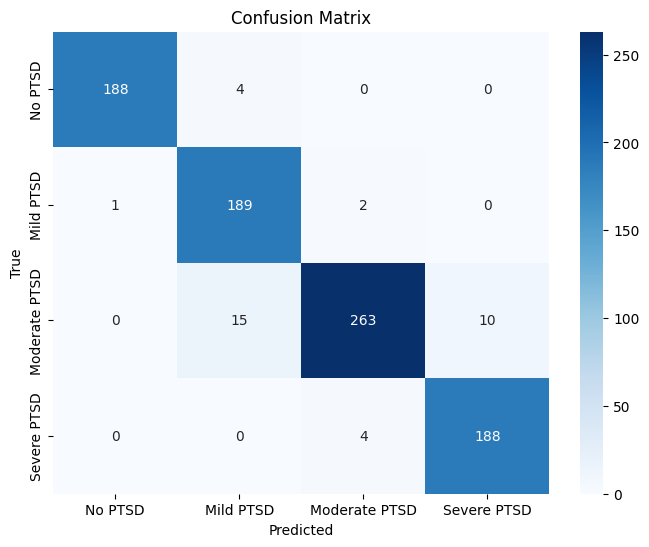

Sensitivity: [0.97916667 0.984375   0.91319444 0.97916667]
Specificity: [0.7802325581386277, 0.7584204413463898, 0.6793802145403106, 0.76976744185957]


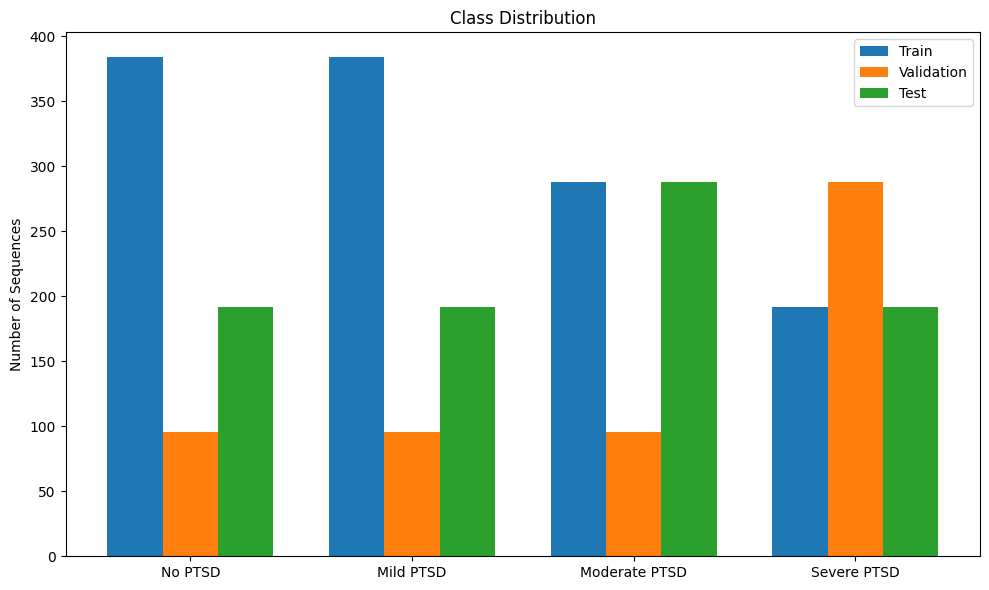

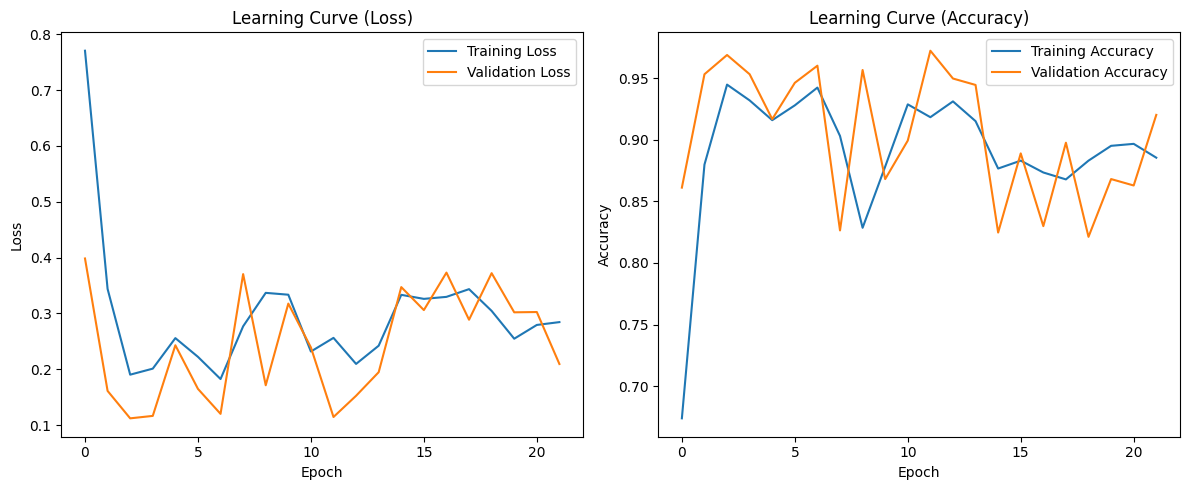

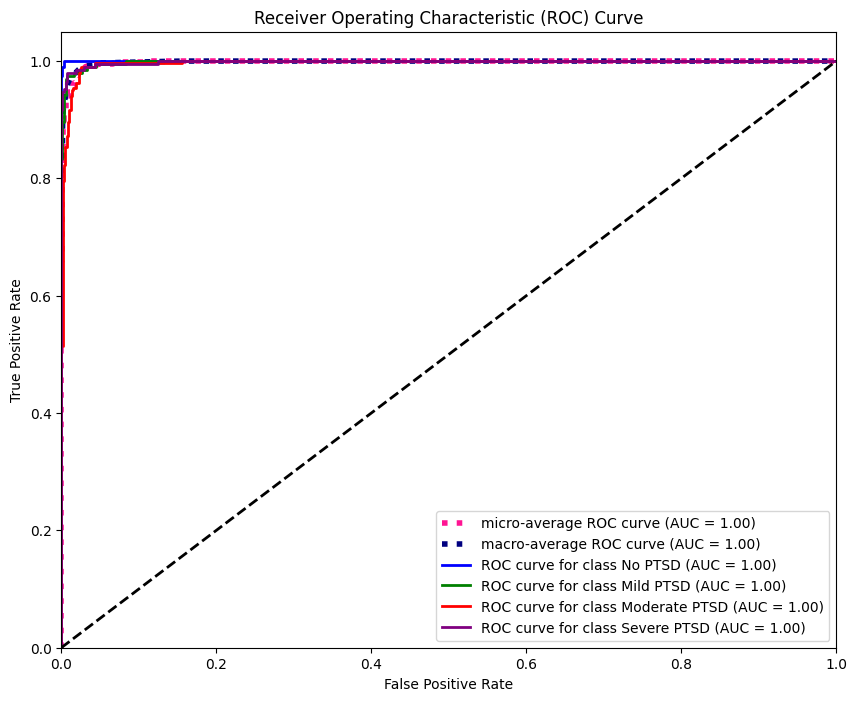

In [ ]:
def compute_class_weights(labels_list, num_classes):
    counts = Counter(labels_list)
    total = len(labels_list)
    weights = [0.0] * num_classes
    for i in range(num_classes):
        if counts.get(i, 0) > 0:
            weights[i] = total / (num_classes * counts[i])
        else:
            weights[i] = 1.0
    return torch.tensor(weights, dtype=torch.float32)

def plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies, results_dir):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Learning Curve (Loss)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Learning Curve (Accuracy)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'learning_curve.png'))
    plt.show()

def plot_class_distribution(train_labels, val_labels, test_labels, target_names, results_dir):
    plt.figure(figsize=(10, 6))
    
    train_counts = Counter(train_labels)
    val_counts = Counter(val_labels)
    test_counts = Counter(test_labels)

    labels = target_names
    x = np.arange(len(labels))
    width = 0.25

    plt.bar(x - width, [train_counts.get(i, 0) for i in range(len(labels))], width, label='Train')
    plt.bar(x, [val_counts.get(i, 0) for i in range(len(labels))], width, label='Validation')
    plt.bar(x + width, [test_counts.get(i, 0) for i in range(len(labels))], width, label='Test')

    plt.ylabel('Number of Sequences')
    plt.title('Class Distribution')
    plt.xticks(x, labels)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, 'class_distribution.png'))
    plt.show()

def plot_roc_curve(y_true, y_prob, num_classes, target_names, results_dir):
    y_true_binarized = label_binarize(y_true, classes=range(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    colors = ['blue', 'green', 'red', 'purple']
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label=f'ROC curve for class {target_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(results_dir, 'roc_curve.png'))
    plt.show()


def train_and_evaluate():
    ROOT_DIR = './PTSD_Dataset/'
    RESULTS_DIR = './results/'
    LABELS_FILE = 'labels.csv'
    SEQ_LEN = 10
    BATCH_SIZE = 32
    NUM_HRV_FEATURES = 5
    NUM_CLASSES = 4
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    os.makedirs(RESULTS_DIR, exist_ok=True)

    print("Loading dataset and preprocessing (this may take time)...")
    dataset = PTSDDataset(ROOT_DIR, LABELS_FILE, sequence_length=SEQ_LEN)

    if len(dataset) == 0:
        print("No sequences found. Check your EDF files and labels.csv.")
        return

    df = pd.DataFrame(dataset.sequences)
    
    df['subject_label'] = df.apply(lambda row: f"{row['subject_id']}-{row['label']}", axis=1)
    
    unique_subjects = df['subject_id'].unique()
    y_subjects = df.groupby('subject_id')['label'].first().values
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    
    for train_index, test_index in sss.split(unique_subjects, y_subjects):
        train_subjects_all = unique_subjects[train_index]
        test_subjects = unique_subjects[test_index]
        
    sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2 / 0.7, random_state=42)
    y_train_val = df[df['subject_id'].isin(train_subjects_all)].groupby('subject_id')['label'].first().values
    for train_index_final, val_index in sss_val.split(train_subjects_all, y_train_val):
        train_subjects = train_subjects_all[train_index_final]
        val_subjects = train_subjects_all[val_index]

    train_df = df[df['subject_id'].isin(train_subjects)]
    val_df = df[df['subject_id'].isin(val_subjects)]
    test_df = df[df['subject_id'].isin(test_subjects)]

    print(f"Subjects -> total: {len(unique_subjects)}, train: {len(train_subjects)}, val: {len(val_subjects)}, test: {len(test_subjects)}")
    print(f"Sequences -> train: {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")

    train_dataset_subset = torch.utils.data.Subset(dataset, train_df.index.tolist())
    val_dataset_subset = torch.utils.data.Subset(dataset, val_df.index.tolist())
    test_dataset_subset = torch.utils.data.Subset(dataset, test_df.index.tolist())

    train_loader = DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset_subset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset_subset, batch_size=BATCH_SIZE, shuffle=False)

    y_train_labels = [int(train_df.iloc[i]['label']) for i in range(len(train_df))]
    class_weights = compute_class_weights(y_train_labels, NUM_CLASSES).to(DEVICE)

    model = PTSD_HybridModel(NUM_HRV_FEATURES, NUM_CLASSES, SEQ_LEN, device=DEVICE).to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    best_val_acc = 0.0
    patience = 10
    patience_counter = 0
    max_epochs = 100
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(max_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch in train_loader:
            eeg_batch = batch['eeg_seq'].to(DEVICE)
            hrv_batch = batch['hrv_seq'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            optimizer.zero_grad()
            logits = model(eeg_batch, hrv_batch)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_correct += (logits.argmax(dim=1) == labels).sum().item()
            train_total += labels.size(0)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                eeg_batch = batch['eeg_seq'].to(DEVICE)
                hrv_batch = batch['hrv_seq'].to(DEVICE)
                labels = batch['label'].to(DEVICE)

                logits = model(eeg_batch, hrv_batch)
                loss = loss_fn(logits, labels)

                val_loss += loss.item() * labels.size(0)
                val_correct += (logits.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)

        train_acc = train_correct / train_total if train_total > 0 else 0.0
        val_acc = val_correct / val_total if val_total > 0 else 0.0

        train_losses.append(train_loss / max(1, train_total))
        val_losses.append(val_loss / max(1, val_total))
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{max_epochs} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(RESULTS_DIR, 'best_model.pt'))
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    best_path = os.path.join(RESULTS_DIR, 'best_model.pt')
    if os.path.exists(best_path):
        model.load_state_dict(torch.load(best_path, map_location=DEVICE))
    model.eval()

    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for batch in test_loader:
            eeg_batch = batch['eeg_seq'].to(DEVICE)
            hrv_batch = batch['hrv_seq'].to(DEVICE)
            labels = batch['label'].to(DEVICE)

            logits = model(eeg_batch, hrv_batch)
            preds = logits.argmax(dim=1)
            probs = F.softmax(logits, dim=1)

            y_pred.extend(preds.cpu().numpy().tolist())
            y_true.extend(labels.cpu().numpy().tolist())
            y_prob.extend(probs.cpu().numpy().tolist())

    y_prob = np.array(y_prob)
    target_names = ['No PTSD', 'Mild PTSD', 'Moderate PTSD', 'Severe PTSD']
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, labels=[0, 1, 2, 3], target_names=target_names, zero_division=0))

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'))
    plt.show()

    sensitivity = np.diag(cm) / (cm.sum(axis=1) + 1e-9)
    specificity = []
    for i in range(NUM_CLASSES):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum()
        specificity.append(tn / (tn + fp + 1e-9))
        
    print(f"Sensitivity: {sensitivity}")
    print(f"Specificity: {specificity}")
    
    train_labels_for_plots = [int(t['label']) for t in train_df.to_dict('records')]
    val_labels_for_plots = [int(v['label']) for v in val_df.to_dict('records')]
    test_labels_for_plots = [int(t['label']) for t in test_df.to_dict('records')]

    plot_class_distribution(train_labels_for_plots, val_labels_for_plots, test_labels_for_plots, target_names, RESULTS_DIR)
    plot_learning_curve(train_losses, val_losses, train_accuracies, val_accuracies, RESULTS_DIR)
    plot_roc_curve(y_true, y_prob, NUM_CLASSES, target_names, RESULTS_DIR)


if __name__ == '__main__':
    os.makedirs('./results', exist_ok=True)
    train_and_evaluate()

### 5. Summary and Repository Link
As you can see, this demo trains the model using the data and provides evaluation results by displaying a classification report and a confusion matrix.

All the code for this project is available in the following repository:

https://github.com/Dnyesf/PTSD-Detection-EEG-HRV.git

I hope this demo is useful for your presentation. If you need further edits or changes to this file, please let me know.